<h2>Import Statements</h2>

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

<h2>Data Processing</h2>

In [2]:
player_df = pd.read_csv("/data/Player_Attributes.csv") 
new = player_df.groupby('player_fifa_api_id')['overall_rating'].idxmax(axis=0)
# create index list that contains the index of each player with his max rating
index_list = new.to_frame()['overall_rating'].tolist()
# get rid the nans in the list 
newlist = [x for x in index_list if math.isnan(x) == False]
# make every number in index list a int
newlist = [int(x) for x in newlist]
# filter by index list to create new player_df
player_df = player_df.iloc[newlist]
# get rid of useless columns
player_df.drop(["id", "player_fifa_api_id", "player_api_id", "date"], axis=1, inplace = True)

# create find quality column and apply it to player_df for classification
def find_quality(row):
    overall_rating = row['overall_rating']
    if overall_rating >= 82: 
        return 5
    if overall_rating >= 73 and overall_rating < 82:
        return 4
    if overall_rating >= 67 and overall_rating < 73:
        return 3
    if overall_rating >= 60 and overall_rating < 67:
        return 2
    if overall_rating < 60:
        return 1

# create column called overall quality for classification 
player_df['overall_quality'] = player_df.apply(find_quality, axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<h2>Correlation Matrix</h2>

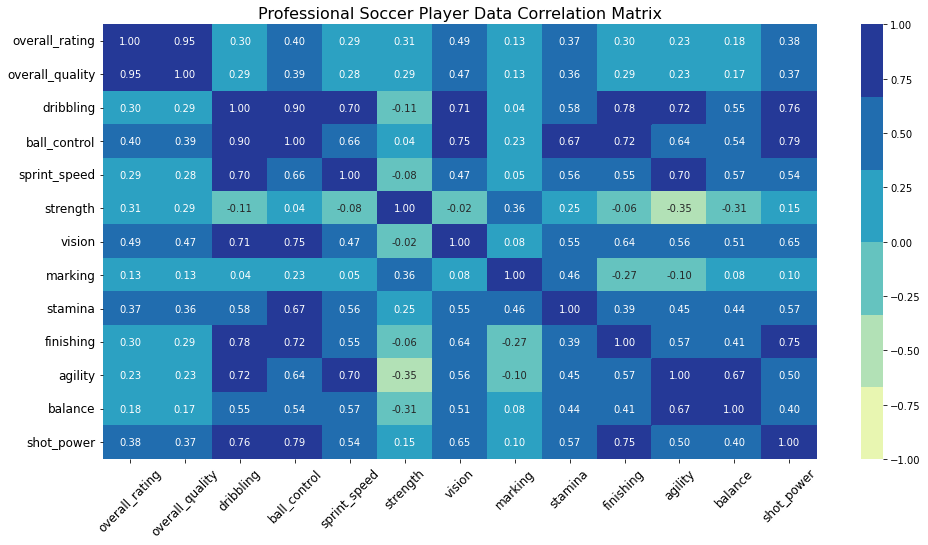

              var1             var2      corr
1   overall_rating  overall_quality  0.952038
24       dribbling     ball_control  0.900622
42    ball_control       shot_power  0.789128
30       dribbling        finishing  0.784016
33       dribbling       shot_power  0.756943
36    ball_control           vision  0.748233
75       finishing       shot_power  0.748190
39    ball_control        finishing  0.719727
 
            var1       var2      corr
55      strength    agility -0.348107
56      strength    balance -0.305204
65       marking  finishing -0.266998
26     dribbling   strength -0.112711
66       marking    agility -0.095133
43  sprint_speed   strength -0.083868
54      strength  finishing -0.056071
51      strength     vision -0.024944


In [3]:
# first narrow down which columns we want to use 
smaller_player_df = player_df[["overall_rating", "overall_quality", "attacking_work_rate", "defensive_work_rate", "dribbling", "ball_control", "sprint_speed", 
                       "strength", "vision", "marking", "stamina", "finishing", "agility", "balance", "shot_power"]]
player_corr = smaller_player_df.corr()
player_corr = player_corr.unstack().drop_duplicates().reset_index()
player_corr = player_corr.rename(columns = {'level_0':'var1', 'level_1':'var2',0:'corr'})
player_corr = player_corr[player_corr['var1'] != player_corr['var2']]

# create a heatmap to visualize the correlations among all the variables
plt.figure(figsize=(16, 8))
heatmap = sns.heatmap(smaller_player_df.corr(),cmap=sns.color_palette("YlGnBu"), annot=True, vmin=-1, vmax=1, fmt=".2f")
heatmap.set_title('Professional Soccer Player Data Correlation Matrix', size=16)
heatmap.tick_params(axis="x", rotation=45, labelsize = 12)
heatmap.tick_params(axis="y", labelsize = 12)
plt.show()

# print top correlation values
print(player_corr.sort_values(by = 'corr',ascending=False)[0:8])
print(" ")
print(player_corr.sort_values(by = 'corr')[0:8])


<h2>Visualizations of Variables of Interest</h2>

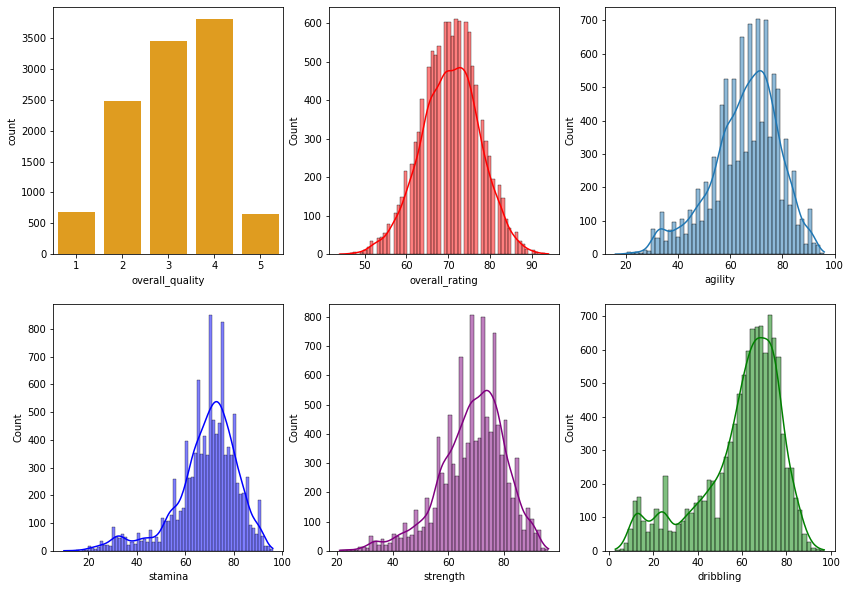

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10))
# create count and histogram plots 
sns.countplot(data=player_df, x="overall_quality", color="orange", ax=axs[0,0])
sns.histplot(data=player_df, x="overall_rating", kde=True, color="red", ax=axs[0, 1])
sns.histplot(data=player_df, x="agility", kde=True, ax=axs[0,2])
sns.histplot(data=player_df, x="stamina", kde=True, color="blue", ax=axs[1,0])
sns.histplot(data=player_df, x='strength', kde=True, color='purple', ax=axs[1,1])
sns.histplot(data=player_df, x='dribbling', kde=True, color="green", ax=axs[1,2])

plt.show()

<h2>ANOVA</h2>

In [5]:
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

box_office_lm = ols('strength ~ overall_quality', data=player_df).fit()
table = sm.stats.anova_lm(box_office_lm, typ=1)
print("ANOVA Between Vision and Overall_Quality:")
display(table)

box_office_lm = ols('dribbling ~ overall_quality', data=player_df).fit()
table = sm.stats.anova_lm(box_office_lm, typ=1)
display(table)

box_office_lm = ols('agility ~ overall_quality', data=player_df).fit()
table = sm.stats.anova_lm(box_office_lm, typ=1)
display(table)

box_office_lm = ols('stamina ~ overall_quality', data=player_df).fit()
table = sm.stats.anova_lm(box_office_lm, typ=1)
display(table)



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ANOVA Between Vision and Overall_Quality:


,df,sum_sq,mean_sq,F,PR(>F)
overall_quality,1.0,1.255007e+05,125500.658614,995.657152,2.529109e-209
Residual,11058.0,1.393840e+06,126.048066,NaN,NaN


,df,sum_sq,mean_sq,F,PR(>F)
overall_quality,1.0,3.168113e+05,316811.308940,1026.51575,1.808877e-215
Residual,11058.0,3.412806e+06,308.627811,NaN,NaN


,df,sum_sq,mean_sq,F,PR(>F)
overall_quality,1.0,9.222960e+04,92229.595522,571.295933,5.155717e-123
Residual,10580.0,1.708027e+06,161.439265,NaN,NaN


,df,sum_sq,mean_sq,F,PR(>F)
overall_quality,1.0,2.497474e+05,249747.377286,1653.744909,0.0
Residual,11058.0,1.669971e+06,151.019287,NaN,NaN


<h2>Splitting Data</h2>

In [6]:
train,test = train_test_split(player_df, test_size=0.2)

#For regression
X_train_reg = train.drop(["overall_rating", "overall_quality"], axis=1)
y_train_reg = train["overall_rating"].copy()
X_test_reg = test.drop(["overall_rating", "overall_quality"], axis=1)
y_test_reg = test["overall_rating"].copy()

#For Classification
X_train = train.drop(["overall_quality"], axis=1)
y_train = train["overall_quality"].copy()
X_test = test.drop(["overall_quality"], axis=1)
y_test = test["overall_quality"].copy()

<h2>Data Preperation</h2>

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


from sklearn.preprocessing import StandardScaler

# Regression Pipeline 
num_attribs_reg = list(X_train_reg.select_dtypes(include=[np.number]))
cat_attribs_reg = list(X_train_reg.select_dtypes(exclude=[np.number]))

num_pipeline_reg = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline_reg = ColumnTransformer([                          
        ("num", num_pipeline_reg, num_attribs_reg),
        ("cat", OneHotEncoder(), cat_attribs_reg),
    ])

X_train_prepared_reg = full_pipeline_reg.fit_transform(X_train_reg)
X_test_prepared_reg = full_pipeline_reg.transform(X_test_reg)

# Classification Pipeline
num_attribs = list(X_train.select_dtypes(include=[np.number]))
cat_attribs = list(X_train.select_dtypes(exclude=[np.number]))

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([                          
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

# Fit and train model on training data. ONLY Transform on test. 
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

<h2>Linear Regression</h2>

In [8]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error


final_rating = test['overall_rating']

#build linear regression model and fit data
lm = LinearRegression()
lm.fit(X_train_prepared_reg, y_train_reg)

#linear regression predictions
predictions_reg = lm.predict(X_test_prepared_reg)

lin_mse = mean_squared_error(y_test_reg, predictions_reg)
lin_rmse = np.sqrt(lin_mse) 

#To find accuracy within 6 ratings  
count = 0
for num in range(len(predictions_reg)):
  total = len(predictions_reg)
  if abs(predictions_reg[num] - final_rating.iloc[num]) < 3:
    count = count + 1  
lr_accuracy = count/total * 100
print("accuracy = " + str(lr_accuracy))
print('MSE = ' + str(lin_mse))
print('RMSE = ' + str(lin_rmse))

accuracy = 76.17540687160941
MSE = 6.83874473778723
RMSE = 2.6150993743617525


From my analysis, I found that there was only 77.3% accuracy. 

Furthermore, the MSE score was around 6.9, implying that the average distance between the observed overall rating and the predicted ratings was around 6.9. 

Additionally, the RMSE score was 2.6, which implies that this model will predict a player’s overall rating wrong around 26% of the time.

<h2>Classification</h2>

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


# create list for all the names of the classification models 
names = ["Nearest Neighbors", "Linear SVM", "Decision Tree", "Random Forest",
          "Neural Net", "AdaBoost","Naive Bayes"]

# create list of model classifiers
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()
    ]

# rename training and testing data 
X_train = X_train_prepared
y_train = y_train
X_test = X_test_prepared
y_test = y_test

# run through all classification models 
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # evaluate predictions
    accuracy = clf.score(X_test, y_test)
    print("%s Accuracy: %.2f%%" % (name,accuracy * 100.0))

Nearest Neighbors Accuracy: 78.03%
Linear SVM Accuracy: 94.17%
Decision Tree Accuracy: 100.00%
Random Forest Accuracy: 68.76%
Neural Net Accuracy: 97.29%
AdaBoost Accuracy: 77.71%
Naive Bayes Accuracy: 32.10%


The Linear SVM, Decision Tree, and Neural Net classifiers were the most
accurate at predicting a player's overall_quality.

<h2>Voting Classifier</h2>

In [21]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score

# choose 3 models to be put in the voting classifier
clf1 = KNeighborsClassifier(3)
clf2 = SVC(kernel="linear", C=0.025)
clf3 = DecisionTreeClassifier(max_depth=5)
clf4 = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
clf5 = MLPClassifier(alpha=1, max_iter=1000)
clf6 = AdaBoostClassifier()
clf7 = GaussianNB()

vclf = VotingClassifier(estimators=[('clf1', clf1), ('svcv', clf2), ('dtc', clf3), ('rf', clf4), ('mlpc', clf5), ('clf6', clf6), ('gnb', clf7)], voting='hard')

vclf.fit(X_train_prepared, y_train)
y_predictions = vclf.predict(X_test_prepared)
y_predictions
accuracy = vclf.score(X_test_prepared, y_test)

print(classification_report(y_test, y_predictions))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

              precision    recall  f1-score   support

           1       0.99      0.94      0.97       147
           2       0.97      0.93      0.95       493
           3       0.95      0.99      0.97       670
           4       0.98      0.99      0.99       784
           5       1.00      0.89      0.94       118

    accuracy                           0.97      2212
   macro avg       0.98      0.95      0.96      2212
weighted avg       0.97      0.97      0.97      2212

Accuracy: 96.88%


The Voting Classifier, gave an accuracy of 96.88% with a weighted f1-score of 0.97